# Around Black-Scholes and Local Volatility

We offer you the following practical task on Black-Scholes and local volatility models. 

Total score is **100**, which will be converted to $22\%$ of the course grade. You have $1$ month for this work. **Deadline is 1st of December, 23:59 MSK**.

The file must be sent to **stoch-vol-23-fall@yandex.ru** with topic "stoch-vol Lab1".  Please rename your file as **"SurnameName_Lab1.ipynb"** before sending. 

If you have any questions feel free to ask in Telegram https://t.me/v_antipov or https://t.me/igortao.

**Full name:**
Cherepakhin Ivan

**Faculty:**
MSU Mechanics Mathematics

## Episode 0: Import all python modules you wish 💅 (0 points)

In [2]:
### YOUR IMPORTS HERE

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st
from collections.abc import Callable
from tqdm.auto import trange

In [7]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats  
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [5]:
DARK_THEME = True

if DARK_THEME:
    plt.style.use("dark_background")
    mpl.rcParams["figure.facecolor"] = "none"
    mpl.rcParams["axes.facecolor"] = "none"

---

## Episode 1: Around Black-Scholes model 🧠 (50 points)

**1**. 💅 <span style="color:blue">(10 points)</span>  

A call spread is an option strategy in which a call option is bought, and another less expensive call option is sold. That is, the payoff of the call spread at expiration $T$ can be given as 

$$\text{Call-spread}(K_1, K_2) = (S_T - K_1)_{+} - (S_T - K_2)_{+}, \qquad K_1 < K_2.$$

Plot **call-spread** option prices as functions of the underlying asset price for different **exercise times** and different **volatilities**. Use parameters 

$$K_1 = 1, \quad K_2 = 1.2, \quad r = 0, \quad S \in [0.5, 1.5],$$

and $T \in \{0,\ \frac{1}{4},\ \frac{1}{2},\ \frac{3}{4},\ 1\}$ (time is measured in years) and $\sigma \in \{0.1, \ 0.2, \ 0.3\}$.

*Note: the answer should contain three plots (for each volatility $\sigma$), each of which shows option prices for different excercise times $T$.*

### Solution.
In the first, we put all BS utility.

In [8]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

In [9]:
@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]]
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        
@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)    

@dataclass
class BSParams:
    volatility: Floats

In [10]:
def dt(option: StockOption, ms: MarketState):
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)


def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

In [11]:
def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    
    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price
    
    return np.where(option.is_call, call_price, put_price)

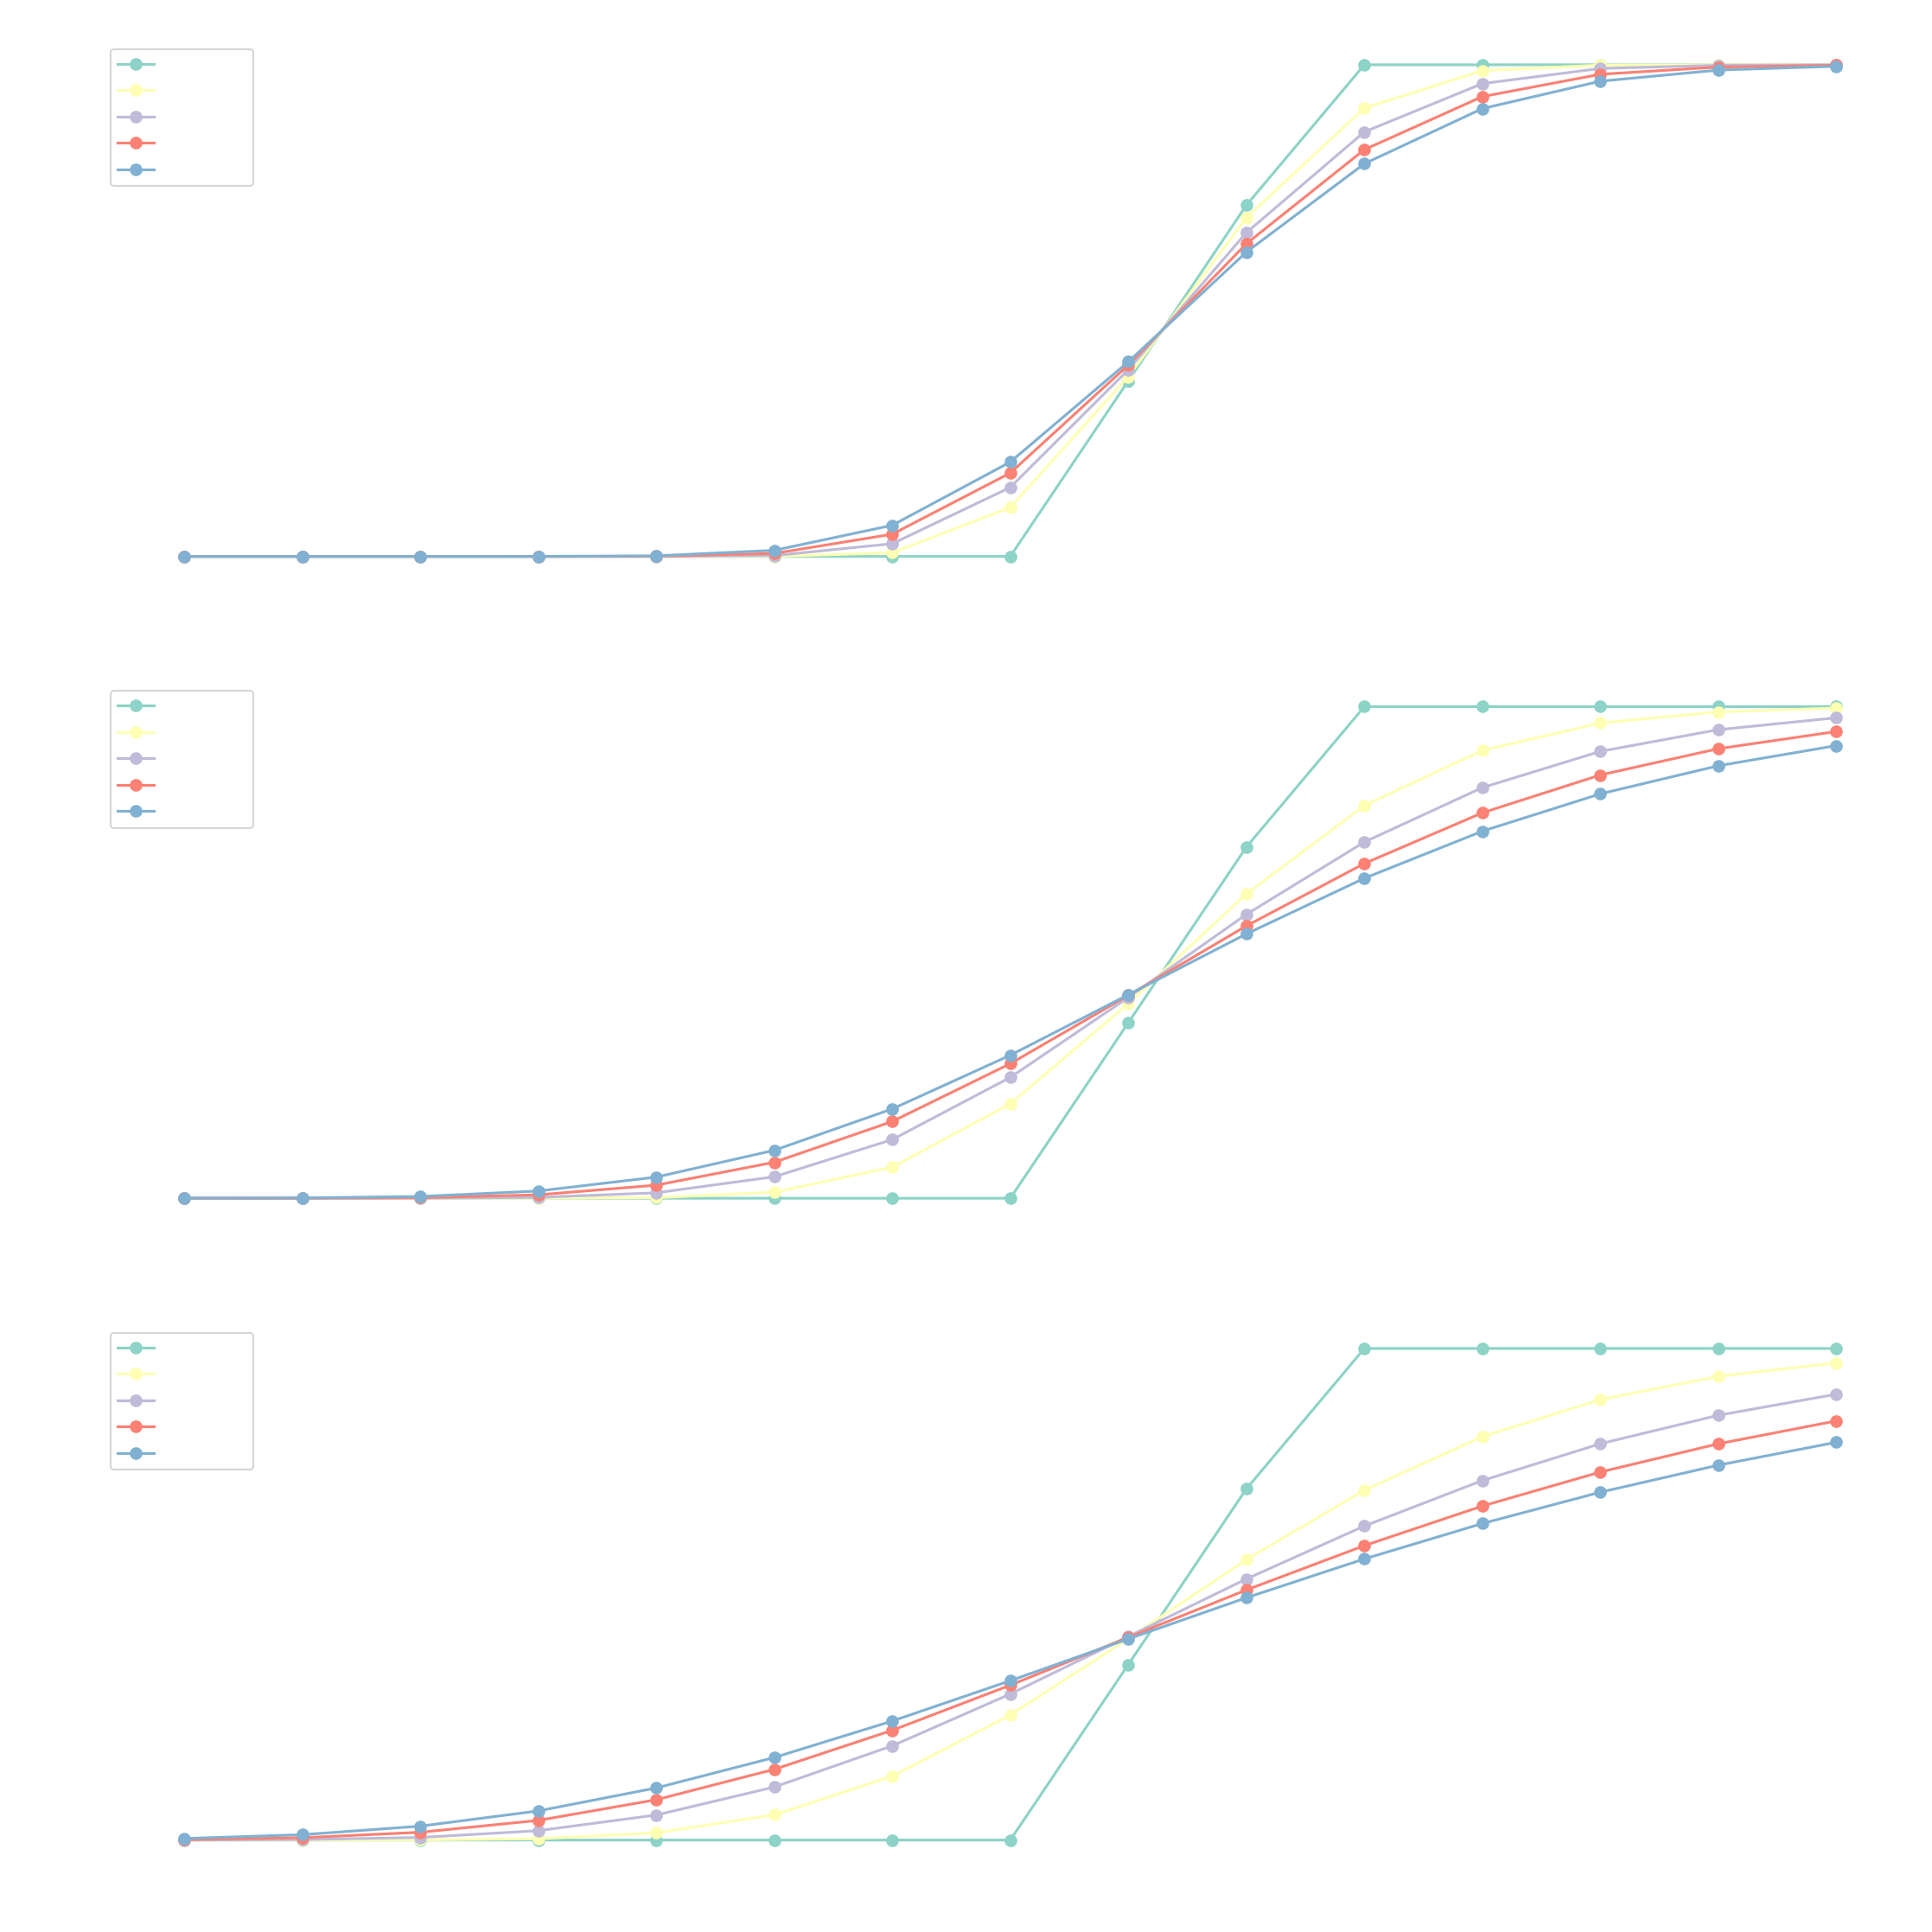

In [22]:
r = 0
S = 1
Sigma = [0.1, 0.2, 0.3]
S_ax = np.linspace(0.5, 1.5, 15)

K_1 = 1
K_2 = 1.2
times = np.linspace(0, 1, 5)

option_expensive = CallStockOption(strike_price=np.array(K_1),
                      expiration_time=times[:, None])
option_chiper = CallStockOption(strike_price=np.array(K_2),
                      expiration_time=times[:, None])


ms = MarketState(stock_price=S_ax, interest_rate=r)

fig, axs = plt.subplots(nrows=3, figsize=(15, 15), dpi=150)

for (sigma, ax) in zip(Sigma, axs):
    params = BSParams(volatility=sigma)
    ax.plot(S_ax, price(option_expensive, ms, params).T - price(option_chiper, ms, params).T, "o-", label=list(map(lambda x : "T = " + str(x) , times)))
    ax.set_title(f"Sigma = {sigma}")
    ax.set_xlabel("Spot price, $")
    ax.set_ylabel("Price call option, $")
    ax.legend()

plt.tight_layout()
plt.show()


---

**2**. 💅 <span style="color:blue">(10 points)</span>  What kind of dependence on the parameters of call-spread option price do you observe? How does the price of it depend on the spot price $S$, volatility $\sigma$ and time to expiration $T$? Why? Provide the intuition. 

Чем меньше $\sigma, T$, тем цена ближе к графику выплаты bull spred. Чем больше $\sigma$, тем меньше цена стратегии, аналогичено и временем экспирации опционов. Интуиция здесь такова, что мы хотим заработать на спреде от страйка опциона при этом это выйдет дешевле(см. дз№1), чем купить просто call опцион. Из графика видно(также из аналитических соображений), что для опционов OTM мы имеем очень низкую стоимость, и это естественно вытекает из соображений вероятности исполнения этих контрактов. Те же соображения и в обратной ситуации, когда оба опциона ITM. Изучим по подробнее связь $T$ и цены. Рассмотрим график цены до $K_1$. На этом промежутке начальных спотовых цен(т.е. OTM) чем меньше время, тем дешевле стратегия. Интуиция этого такова, что вероятность исполнения стратегии за меньший промежуток времени меньше, чем в иных случаях. Та же ситуация для ITM. Для $\sigma$ интуиция подсказвает, что чем она меньше, тем меньше колебания цен underlying asset, и далее снова анализируем отдельные промежутки спотовых цен. Для OTM получаем, что если $\sigma$ мала, то и вероятность дойти до страйка невелика.

---

**4**. 💅 <span style="color:blue">(10 points)</span> Replicate considered call-spread option using the portfolio rebalanced $n$ times (i.e. every $dt = T/n$ units of time). Using simulations, estimate the distribution of the replication error.


    1) Generate m random trajectories of price process trajectories on the segment [0,t] with a step dt = T/n.

    2) For each trajectory at each moment of time, find a replicating portfolio. Assume that the initial value of the portfolio is equal to the option price.

    3) For each trajectory, calculate the difference between the value of the replicating portfolio at time T and the payout to be made on the option.

    4) Display the distribution of the obtained differences in the form of a histogram.

*Note: use, for instance, $m = 2^{10} - 1$ and $n$ = 123*. 

*Note: Remember that you are replicating your call-spread in Black-Scholes model. So, you may use any formulas available in this model (Black-Scholes option's price formula, greeks, etc.) .* 

In [26]:
def make_bsm_market_simulator(
    ms: MarketState,
    params: BSParams,
    time_stop: float,
    n_steps: int = 200,
):
    
    def simulate(n_paths: int, seed: int = 0xB0BA_C_3AB0DA):
        dt = (time_stop - ms.time) / n_steps
        random = np.random.default_rng(seed)
        norm = random.normal(size=(n_paths, n_steps))
        d_log_s = (
            (ms.interest_rate - params.volatility ** 2 / 2) * dt
            + params.volatility * norm * np.sqrt(dt)
        )
        d_log_s = np.insert(d_log_s, 0, np.zeros(n_paths), axis=1)
        return ms.stock_price * np.exp(np.cumsum(d_log_s, axis=-1))
    
    return simulate

In [23]:
def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = stats.norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)

def calc_hedging_pnl(
    option: StockOption,
    ms: MarketState,
    params: BSParams,
    n_steps: int = 200,
    n_paths: int = 1000,
    seed: int = 0xB0BA_C_3AB0DA,
):
    sim_fn = make_bsm_market_simulator(ms, params, option.expiration_time, n_steps)
    paths = sim_fn(n_paths, seed)                                            # paths.shape == (n_paths, n_steps + 1)
    times = np.linspace(ms.time, option.expiration_time, n_steps + 1)[None]  # times.shape == (1,       n_steps + 1)
    bank_acc = 1.0 * np.exp(ms.interest_rate * (times - times[:, 0]))
    df = 1.0 / bank_acc
    
    inter_ms = MarketState(
        stock_price=paths,
        interest_rate=ms.interest_rate,
        time=times,
    )
        
    opt_p = price(option, inter_ms, params)
    stock_pos = delta(option, inter_ms, params)
    bank_acc_pos = df * (opt_p - stock_pos * paths)
    hedging_pnl = (
        stock_pos[:, :-1] * np.diff(paths, axis=-1)
        + bank_acc_pos[:, :-1] * np.diff(bank_acc, axis=-1)
    )
    payoff = -option.payoff(paths[:, [-1]])
    return np.append(hedging_pnl, payoff, axis=-1)

In [28]:
n = 123
m = 2**10 - 1
T = 1.0

option_expensive = CallStockOption(strike_price=1.0, expiration_time=1.0)
option_chiper = CallStockOption(strike_price=1.2, expiration_time=1.0)
ms = MarketState(stock_price=1.0, interest_rate=0.0)
params = BSParams(volatility=0.1)

In [36]:
pl_expensive = -calc_hedging_pnl(
    option_expensive,
    ms,
    params,
    n_paths=n,
    n_steps=m,
    seed=42,
).sum(-1)

pl_chiper = -calc_hedging_pnl(
    option_chiper,
    ms,
    params,
    n_paths=n,
    n_steps=m,
    seed=42,
).sum(-1)

pl_total = pl_expensive - pl_chiper

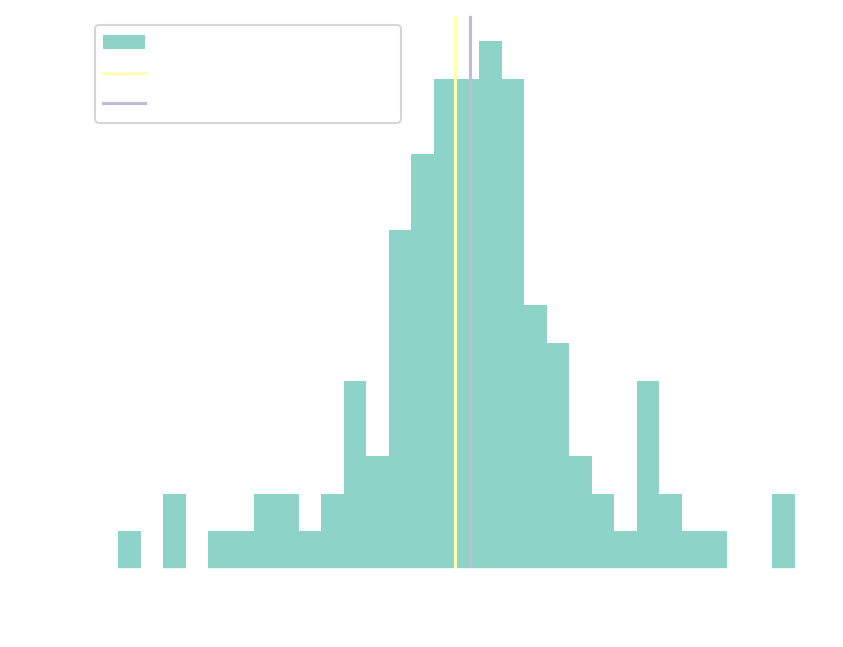

In [38]:
p = price(option_expensive, ms, params) - price(option_chiper, ms, params)

_, ax = plt.subplots(dpi=150)
ax.hist(pl_total, bins=30, label="P&L histogram")
ax.axvline(p, c="C1", label="Option price")
ax.axvline(pl_total.mean(), c="C2", label="Mean replication price")
ax.set_xlabel("Replication in the BSM model")
ax.set_ylabel("Count")
ax.legend()
plt.show()

---

**5**. 🧠 <span style="color:blue">(20 points)</span> Let $C_{call} (S_t, r, \sigma, t) := C(t, S_t)$ be a call option price where $C(t, S)$ satisfies BS equation. Suppose that we sell a call option at $t=0$ at implied volatility $\hat \sigma$, i.e. we get the premium $C_{call}(S_0, r, \hat \sigma, 0)$. Hence the hedging strategy is such that the number of the risky asset held at time $t$ is $$H_t = \dfrac{\partial C}{\partial S}.$$ Moreover, suppose that the true dynamics of asset price is **not** geometric Brownian motion $dS_t = r S_t dt + \sigma S_t dW_t$, but is given by more general Ito process

$$dS_t = \alpha_t S_t dt + \beta_t S_t dW_t. $$  

5.1 <span style="color:blue">(2 points out of 20)</span> Using strategy $H_t$, write SDE for the value $X_t$ of hedging portfolio, assuming that we hold $\dfrac{\partial C}{\partial S}$ units of risky asset and $X_t - \dfrac{\partial C}{\partial S} S_t$ money in riskless one.

Просто подставим все выражения из условия в выражение самофинансируемости $dX_t  = G_tdB_t + H_tdS_t \ .$

\begin{align}
    dX_t
        &= G_t dB_t + H_t dS_t
        \\
        &= \frac{X_t - H_t S_t}{B_t} dB_t + H_t dS_t
        \\
        &= r \cdot \frac{X_t - H_t S_t}{B_t} B_t dt + H_t(\alpha_t S_t dt + \beta_t S_t dW_t)
        \\
        &= ((\alpha_t - r) H_t S_t + r X_t)dt + \beta_t H_t S_t dW_t \ .
\end{align}


Наконец, подставим $H_t = \dfrac{\partial C}{\partial S}$:

$$
dX_t = \left((\alpha_t - r)\dfrac{\partial C}{\partial S}S_t + r X_t\right)dt + \beta_t \dfrac{\partial C}{\partial S} S_t dW_t \ .
$$


5.2 <span style="color:blue">(2 points out of 20)</span> Assume that $Y_t = C(t, S_t)$. Applying Ito formula to $Y_t$, write SDE for $Y_t$.  

$$
d Y_t = \left(\dfrac{\partial Y}{\partial t}  + \alpha_t S_t \dfrac{\partial Y}{\partial S} + \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 Y}{\partial S^2} \right) dt + \beta_t S_t \frac{\partial Y}{\partial S}dW(t)
$$

5.3 <span style="color:blue">(6 points out of 20)</span> Using answers from 5.1 and 5.2 and BS equation, show that hedging error $Z_t = X_t - Y_t$ satisfies

$$\dfrac{d}{dt} Z_t = r Z_t + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right).$$

$$
\begin{align}
    dZ_t
        &= dX_t - dY_t
        \\
        &= \left((\alpha_t - r) S_t \dfrac{\partial C}{\partial S} + r X_t\right)dt + \beta_t S_t \dfrac{\partial C}{\partial S} dW_t - \left(\dfrac{\partial Y}{\partial t}  + \alpha_t S_t \dfrac{\partial Y}{\partial S} + \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 Y}{\partial S^2} \right) dt - \beta_t S_t \frac{\partial Y}{\partial S}dW(t)
        \\
        &= \left((\alpha_t - r) S_t \dfrac{\partial C}{\partial S} + r X_t\right)dt - \left(\dfrac{\partial Y}{\partial t}  + \alpha_t S_t \dfrac{\partial Y}{\partial S} + \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 Y}{\partial S^2} \right) dt
        \\
        &= \left( - r S_t \dfrac{\partial C}{\partial S} - \dfrac{\partial Y}{\partial t} + r X_t - \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 Y}{\partial S^2}\right) dt
        \\
        &= \left(\frac{\hat{\sigma}^2}{2}S_t^2 \frac{\partial^2 C}{\partial S^2} - rC(t, S_t) + r X_t - \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 Y}{\partial S^2}\right) dt
        \\
        &= \left(r(X_t -  Y_t) + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right) \right)dt
        \\
        &= \left(r Z_t + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right) \right)dt
\end{align}
$$

5.4 <span style="color:blue">(6 points out of 20)</span> Solve the equation for $Z_t$ above and show that 

$$Z_T = \int_{0}^{T} e^{r(T-s)} \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta_t^2 \right) dt. $$

Возьмем данное представление $Z_t$ и воспользуемся формулой Ито для $Z_t = p(t) e^{rt}$ и найдем явный вид $p(t)$. Обозначим $f(s)=\dfrac{1}{2} S_s^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta_s^2 \right) $. Из задания 5.3 имеем представление: 
$$
\frac{d}{dt}Z_t = r Z_t + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right) = r Z_t + f(t) \ .
$$
Тогда если возьмем производную по $t$ для $Z_t = p(t) e^{rt}$, то получим: 
$$
\frac{d}{dt}Z_t = p' e^{rt} + p r e^{rt} = p' e^{rt} + r Z_t \ .
$$
Соответственно получаем
$$
p' e^{rt} = f(t) \Rightarrow p(t) = \int\limits_0^t  e^{-rs}f(s)ds
$$


5.5 <span style="color:blue">(4 points out of 20)</span> Looking at the results above, is it possible to make a **profit with probability one** even though the true price model is substantially different from the assumed model (GBM)? What condition is sufficient for getting this profit? 

По определению процесс $Z_t$ является величной хеджирующей ошибки, т.е. $Z_t = X_t - Y_t$ и при этом мы знаем closed-form solution, в котором все множители являются положительными, кроме $\left( \hat \sigma^2 - \beta^2_t \right)$. Этот множитель управляет знаком $Z_t$ и из этого можно получить безрисковую прибыль просто в зависимости от знака продавая/покупая портфель и покупая/продавая опцион. 

---

---

## Episode 2: Local volatility from Monte Carlo perspective 🧠 (50 points)

Here you need to implement the Monte-Carlo pricing in Local Volatility model. For that purpose, you can use the standrad *Euler* discretization scheme:

$$S_{t_{i + 1}} = S_{t_i} + \sigma_{Dup}(t_i, S_{t_i}) \Delta W_{t_i}.$$

However, direct usage of such scheme may lead to negative values of the prices $S_t$. For that reason, you may apply the Euler scheme to $\log(S_{t_i})$ and then finally put $S_{t_i} = e^{X_{t_i}}$. From Ito's formula, 

$$X_{t_{i + 1}} = X_{t_i} - \frac{1}{2} \sigma^2_{Dup}(t_i, e^{X_{t_i}}) \Delta t_i+ \sigma_{Dup}(t_i, e^{X_{t_i}}) \Delta W_{t_i}.$$

Notice that for correct implementation, you need a full Dupire volatility surface function. For that reason, you should construct a properly inter-and-extrapolated function $(t, s) \to \sigma_{IV}(t, s)$, obtained from real-market data. Then you may use the well-known formula converting the observed implied volatilites $\sigma_{IV}(t, s)$ to Dupire local volatilies $\sigma_{Dup}(t, s)$: 

$$ \sigma_{Dup}(T, K) = \sqrt{\dfrac{\frac{\partial w}{\partial T}}{1 - \frac{y}{w} \frac{\partial w}{\partial y} + \frac{1}{4} ( -\frac{1}{4} - \frac{1}{w} + \frac{y^2}{w^2}) (\frac{\partial w}{\partial y})^2 + \frac{1}{2} \frac{\partial^2 w}{\partial y^2}}},$$


where 
$w(K, T) = \sigma^{2}_{IV}(K, T) \cdot T$ is implied variance and $y = \log(K / F_T)$ is forward log-moneyness. 

Use, for instace, spline interpolation in $(w, y)$ coordinates. You may use alo flat extrapolation, i.e. for a pair of arguments $(t, K)$, firstly make the following tranformation

$$ t' = \begin{cases} t_{\min}, & t<t_{\min} \\
   t,        & t \in[t_{\min}, t_{\max}],\\
   t_{\max}, & t > t_{\max},
        \end{cases} \qquad

   s = \begin{cases} s_{\min}, & s<s_{\min}, \\
                     s, & s \in[s_{\min}, s_{\max}], \\
                     s_{\\max}, & s > s_{\max},
        \end{cases} \qquad
$$

where $t_{\min}, t_{\max}, s_{\min}, s_{\max}$ - minimum and maximum values of time to expiration and strikes variables from the market data and 
$$\sigma^{new}_{Dup}(t,s) = \sigma_{Dup}(t', s').$$
   

In [2]:
s = 1.0    # spot price S_0
r = 0.0    # zero interest rate

**1**. 🧠 <span style="color:blue">(10 points)</span> 

Extract the data from `data.txt`: strikes, times to expiration and call option prices. Compute the corresponding implied volatilties $\sigma_{IV}(T_i, K_i)$, inter-and-extrapolate them to obtain the whole surface. Plot the calculated implied volatility curves for each time to marutiry $T_i$ and the whole implied volatility surface. 

In [10]:
### YOUR CODE HERE
### Use "lets be rational" implementation of implied volatility calculation from https://github.com/vollib/py_vollib

**2**. 🧠 <span style="color:blue">(20 points)</span> 

Write a function which evaluates a Dupire local volatility at given point, i.e. a function $(t, s) \to \sigma_{Dup}(t, s)$. Please note that it should return an "adequate" value for any input point $(t, s)$ from the considered ranges of strieks and times to expiration. Plot the obtained local volatility surface for a given grid of strikes and times to expiration. 

In [ ]:
### YOUR CODE HERE

### def local_voaltility(t: float, s: float) -> float:
### ...

**3**. 🧠 <span style="color:blue">(20 points)</span> 

Implement a Monte-Carlo simulation calculator and price an option with time to expiration $T = 0.25$ for the range of strikes $K = \{ 0.6, 0.7, 0.8, \dots, 1.4\}$. Your calculator should return a range of prices $\{ V(T, K_i)\}$ and implied volatilites $\sigma_{IV}(T, K_i)$ (for each strike $K_i$), with an absolute error not greater than $1\%$ in implied vols for every (almost every) strike $K_i$. Plot on one graph the prices obtained using Monte Carlo and the prices from the file. Also, plot on other graph the implied vols obtained using Monte Carlo and the implied vols obtained in question (1).

In [9]:
### YOUR CODE HERE